In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import timeit
from matplotlib import pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import itertools

In [16]:
warnings.filterwarnings("ignore")

**Khởi tạo bộ scalers**

In [17]:
# Standardization techniques
scalers = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler(), QuantileTransformer(), Normalizer(), PowerTransformer()]

**Hàm thử nghiệm để tìm ra thuật toán tối ưu cho bài toán**

In [18]:
def test(data, models):  
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X = data.drop('team_win', axis=1)
    y = data['team_win']
    
    model_list = []

    # Loop through models and scalers
    for model in models:
        elapsed_time = {}
        acc_scores = {}
        for scaler in scalers:
            start_time = timeit.default_timer()
            acc = []
            
            # Scale the data
            X_scaled = scaler.fit_transform(X)
            
            # Loop through folds and calculate average accuracy
            for train_index, test_index in kf.split(X_scaled):
                X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Train the model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions on the testing data
                y_pred = model.predict(X_test_scaled)
                
                # Calculate the accuracy of the predictions
                acc.append(accuracy_score(y_test, y_pred))
            
            # Append the accuracy score to the list for this model and scaler
            model_name = f"{type(model).__name__} ({type(scaler).__name__})"
            acc_scores[model_name] = np.mean(acc)
            elapsed_time[model_name] = timeit.default_timer() - start_time
        
        best_model_name = max(acc_scores, key=acc_scores.get)
        model_list.append((best_model_name, acc_scores[best_model_name], elapsed_time[best_model_name]))
        
    sorted_models = sorted(model_list, key=lambda x: (-x[1], x[2]))
        
    return sorted_models[0]
    

**Thử nghiệm trên tập dữ liệu 1k samples và 10k samples đã qua xử lý**

*1. Khởi tạo bộ models thử nghiệm*

In [19]:
models = [LogisticRegression(random_state=42), LinearDiscriminantAnalysis()]
# , SVC(random_state=42)
#           , RandomForestClassifier(random_state=42), DecisionTreeClassifier(random_state=42), XGBClassifier(random_state=42), GaussianNB(),
#           GradientBoostingClassifier(random_state=42), AdaBoostClassifier(random_state=42), BaggingClassifier(random_state=42),
#           KNeighborsClassifier()]

*2. Thử nghiệm để tìm mô hình tốt nhất trên 10 tập dữ liệu 1k samples*

In [25]:
for i in range(10):
    filename = f"data/data extracted/data_fe_1000_part_{i+1}.csv"
    data = pd.read_csv(filename)
    print("File ", filename, "- Best model: ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

File  data/data extracted/data_fe_1000_part_1.csv - Best model:  LinearDiscriminantAnalysis (Normalizer) - Accuracy:  0.767 - Eslaped_time:  0.019330099996295758
File  data/data extracted/data_fe_1000_part_2.csv - Best model:  LinearDiscriminantAnalysis (MinMaxScaler) - Accuracy:  0.7809999999999999 - Eslaped_time:  0.01756369999202434
File  data/data extracted/data_fe_1000_part_3.csv - Best model:  LinearDiscriminantAnalysis (Normalizer) - Accuracy:  0.774 - Eslaped_time:  0.017997699993429706
File  data/data extracted/data_fe_1000_part_4.csv - Best model:  LogisticRegression (MinMaxScaler) - Accuracy:  0.772 - Eslaped_time:  0.1122081000066828
File  data/data extracted/data_fe_1000_part_5.csv - Best model:  LinearDiscriminantAnalysis (MinMaxScaler) - Accuracy:  0.7560000000000001 - Eslaped_time:  0.017777899993234314
File  data/data extracted/data_fe_1000_part_6.csv - Best model:  LogisticRegression (PowerTransformer) - Accuracy:  0.75 - Eslaped_time:  0.06880720000481233
File  data/

*3. Thử nghiệm để tìm mô hình tốt nhất trên tập dữ liệu 10k samples*

*3.1. Thử nghiệm trên tập dữ liệu không xử lý ngoại lệ*

In [26]:
data = pd.read_csv("data/data_fe.csv")
print("Best model for 10k samples: ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

Best model for 10k samples:  LogisticRegression (RobustScaler) - Accuracy:  0.766472995098171 - Eslaped_time:  0.0767168999882415


*3.2. Thử nghiệm trên tập dữ liệu đã xử lý ngoại lệ*

In [28]:
data = pd.read_csv("data/data_fe_cleaned.csv")
print("Best model for 10k samples: ", test(data, models)[0], "- Accuracy: ", test(data, models)[1], "- Eslaped_time: ", test(data, models)[2])

Best model for 10k samples:  LogisticRegression (StandardScaler) - Accuracy:  0.7637092731829573 - Eslaped_time:  0.06621950000408106


***Nhận xét:***
1. *LinearDiscriminantAnalysis cho tỉ lệ chính xác tương đương hoặc nhỉnh hơn đôi chút với LogisticRegression trong trường hợp tập dữ liệu nhỏ (thử nghiệm trên 10 file 1k samples), tuy nhiên thời gian xử lý nhanh hơn*

2. *LogisticRegression cho tỉ lệ chính xác vượt trội hơn so với các mô hình còn lại, và cao hơn so với LinearDiscriminantAnalysis, tuy không nhiều nhưng lại xử lý nhanh hơn*

3. *Kết quả thử nghiệm cho thấy việc xử lý ngoại lệ là không cần thiết (làm giảm độ chính xác từ 0.75657 xuống 0.764)*

***-->*** ***Nên sử dụng LinearDiscriminantAnalysis cho trường hợp dữ liệu nhỏ (1k samples) và LogisticRegression cho trường hợp dữ liệu lớn (10k samples), không cần xử lý ngoại lệ***

**Thử nghiệm loại bớt đặc trưng trên bộ dữ liệu đã xử lý với 2 mô hình được chọn**

*Hàm lựa chọn đặc trưng dựa trên 2 tập dữ liệu*

In [29]:
def feature_selection(file_data, model_for_data, min_acc_score):
    data = pd.read_csv(file_data)

    # Danh sách các trường bạn muốn giữ nguyên
    keep_columns = ['team_win', 'kda_difference_top', 'kda_difference_jungle', 'kda_difference_mid', 'kda_difference_ad', 'kda_difference_sp']
    # Danh sách các trường bạn muốn bỏ đi
    drop_columns = [col for col in data.columns if col not in keep_columns]

    # Duyệt qua các tổ hợp các đặc trưng bằng cách bỏ đi từ 1 đến n đặc trưng
    results = []
    for i in range(1, len(drop_columns)+1):
        for subset in itertools.combinations(drop_columns, i):
            # Bỏ đi các đặc trưng trong tổ hợp hiện tại
            subset_indices = [drop_columns.index(feature) for feature in subset]
            subset_data = data.drop(columns=[drop_columns[i] for i in subset_indices])
            model = test(subset_data, model_for_data)[0]
            acc_score = test(subset_data, model_for_data)[1]
            eslaped_time = test(subset_data, model_for_data)[2]
            results.append((subset, model, acc_score, eslaped_time))

    sorted_models = sorted(results, key=lambda x: x[2], reverse=True)
    if (sorted_models[0][2] >= min_acc_score):
        print(f"{sorted_models[0][0]} - Model: {sorted_models[0][1]} - Acc Score: {sorted_models[0][2]*100:.4f}% - Eslaped Time: {sorted_models[0][3]}")
        return sorted_models[0]
    else:
        print(None)
        return None


*1. Khởi tạo lại bộ mô hình đã chọn: LinearDiscriminantAnalysis cho tập dữ liệu 1k samples, Logistic Regression cho tập dữ liệu 10k samples*

In [30]:
model_for_1ksamples = [LinearDiscriminantAnalysis()]
model_for_10ksamples = [LogisticRegression()]

*2. Thử nghiệm lựa chọn đặc trưng: loại bỏ từng tổ hợp để xem kết quả sau loại bỏ thì độ chính xác có cao hơn không*

In [31]:
print("File data_fe_1000_part_1.csv")
feature_selection('data/data extracted/data_fe_1000_part_1.csv', model_for_1ksamples, test(data, model_for_1ksamples)[1])

print("File data_fe.csv")
feature_selection("data/data_fe.csv", model_for_10ksamples, test(data, model_for_10ksamples)[1])

File data_fe_1000_part_1.csv
('herald_difference', 'score_lane', 'score_role') - Model: LinearDiscriminantAnalysis (Normalizer) - Acc Score: 77.3000% - Eslaped Time: 0.01952329999767244
File data_fe.csv
('Unnamed: 0',) - Model: LogisticRegression (RobustScaler) - Acc Score: 76.5874% - Eslaped Time: 0.07415410000248812


(('Unnamed: 0',),
 'LogisticRegression (RobustScaler)',
 0.7658740930520388,
 0.07415410000248812)

*3. Xóa các đặc trưng không cần thiết để tăng độ chính xác của tập dữ liệu*

In [32]:
data = pd.read_csv("data/data extracted/data_fe_1000_part_1.csv")
data = data.drop(columns=['herald_difference', 'score_lane', 'score_role'], axis=1)
data.to_csv("data/data_1k_featureselection.csv")

***Nhận xét:***
1. *Đối với tập dữ liệu 1k samples, việc loại bỏ bớt các đặc trưng không cần thiết có thể làm tăng độ chính xác (từ 76.4 lên 76.8), tuy nhiên không nhiều.*
2. *Đối với tập dữ liệu 10k samples, việc loại bỏ đặc trưng không làm tăng độ chính xác, chỉ giảm*
**-->** *Tạo lại tập dữ liệu mới cho 1k samples sau khi feature selection, sử dụng dữ liệu này để tính tỉ lệ thắng và giữ nguyên tập dữ liệu cũ cho 10k samples*

**Dự đoán tỉ lệ thắng cho mỗi trận LOL sử dụng 5 fold cross validation dựa trên dữ liệu 1k samples bằng LinearDiscriminantAnalysis, scaler MinMaxScaler, thử nghiệm trên tập kiểm thử. Tính AUC để đánh giá tỉ lệ dự đoán của mô hình**

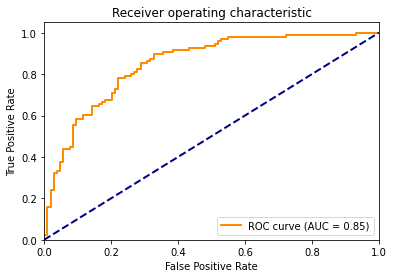

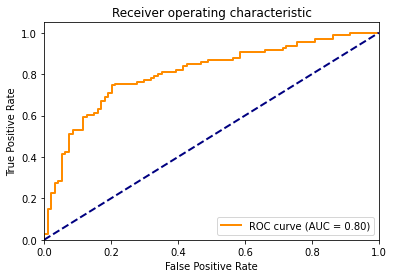

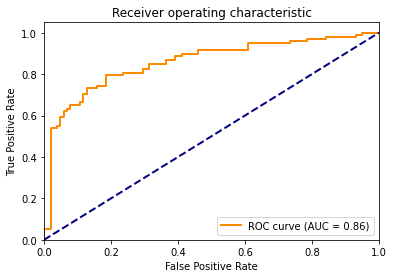

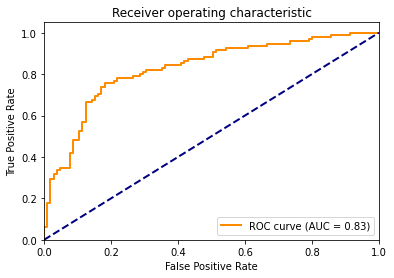

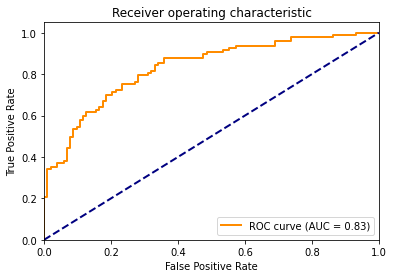

Mean AUC Score for model (Normalizer(), LinearDiscriminantAnalysis()): 0.8338826896804123, Elapsed_time: 0.016307600002619438


In [38]:
models = [(Normalizer(), LinearDiscriminantAnalysis())]
model_names = ["LinearDiscriminantAnalysis"]
data = pd.read_csv("data/data_1k_featureselection.csv")
dfs = []
X = data.drop('team_win', axis=1)
y = data['team_win']
j = 0

elapsed_times = 0
X_cols = X.columns.tolist()

for i, model in enumerate(models):
    auc_scores = []
    X = model[0].fit_transform(X)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        start_time = timeit.default_timer()
        X_train_scaled, X_test_scaled = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(model[1], LogisticRegression):
            clf = LogisticRegression(random_state=42)
        elif isinstance(model[1], LinearDiscriminantAnalysis):
            clf = LinearDiscriminantAnalysis()
        
        clf.fit(X_train_scaled, y_train)
                
        y_pred = clf.predict(X_test_scaled)
        
        # Predict the win probability for the test set
        win_prob = clf.predict_proba(X_test_scaled)[:, 1]
        
        elapsed_time = timeit.default_timer() - start_time

        # Convert win probability to win percentage
        win_percentages = win_prob * 100
        auc_score = roc_auc_score(y_test, win_prob)
        
        auc_scores.append(auc_score)

        X_test_df = pd.DataFrame(X_test_scaled, columns=X_cols)

        # Predict the results on the test set
        y_pred = clf.predict(X_test_df)

        data = []
        for k in range(len(X_test_df)):
            data.append({
                "blue_win_percentage": win_percentages[k],
                "red_win_percentage": 100 - win_percentages[k],
                "team_win": y_test.iloc[k],
                "team_pred": y_pred[k]
            })
        
        fpr, tpr, thresholds = roc_curve(y_test, win_prob)

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        # Create a DataFrame from the list of dicts
        df = pd.DataFrame(data)

        # Save the results to a CSV file
        model_name = model_names[i]
        df.to_csv(f"data/results/result_for_1k/1ksamples_{model_name}_part_{j}.csv", index=False)
        elapsed_times  = elapsed_times+ elapsed_time
    
    print(f"Mean AUC Score for model {model}: {np.mean(auc_scores)}, Elapsed_time: {elapsed_times}")


**Trực quan hóa tỉ lệ thắng dự đoán của mô hình trên các file kết quả**

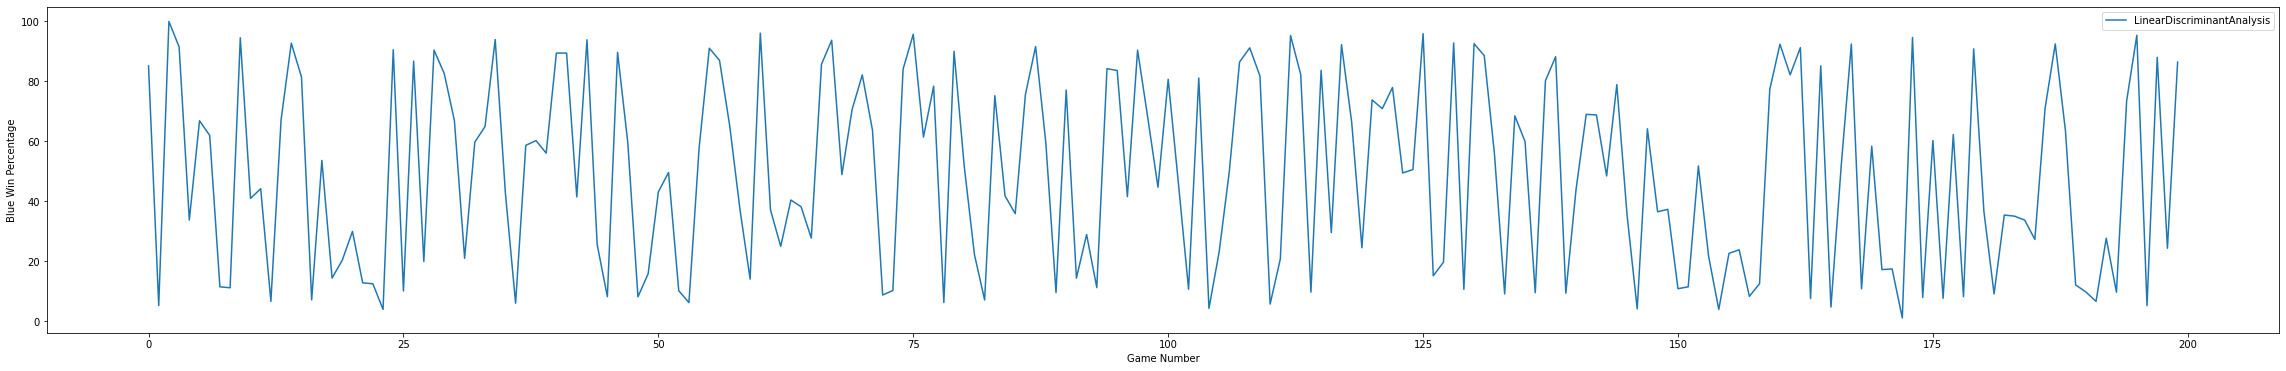

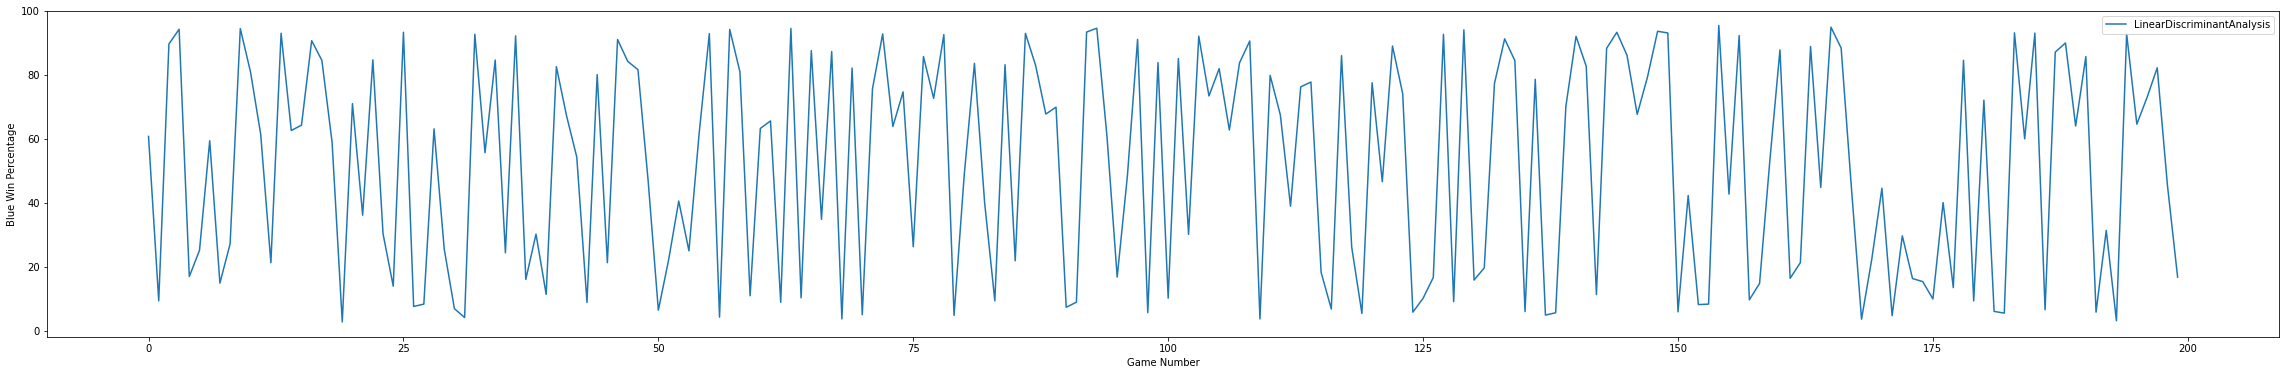

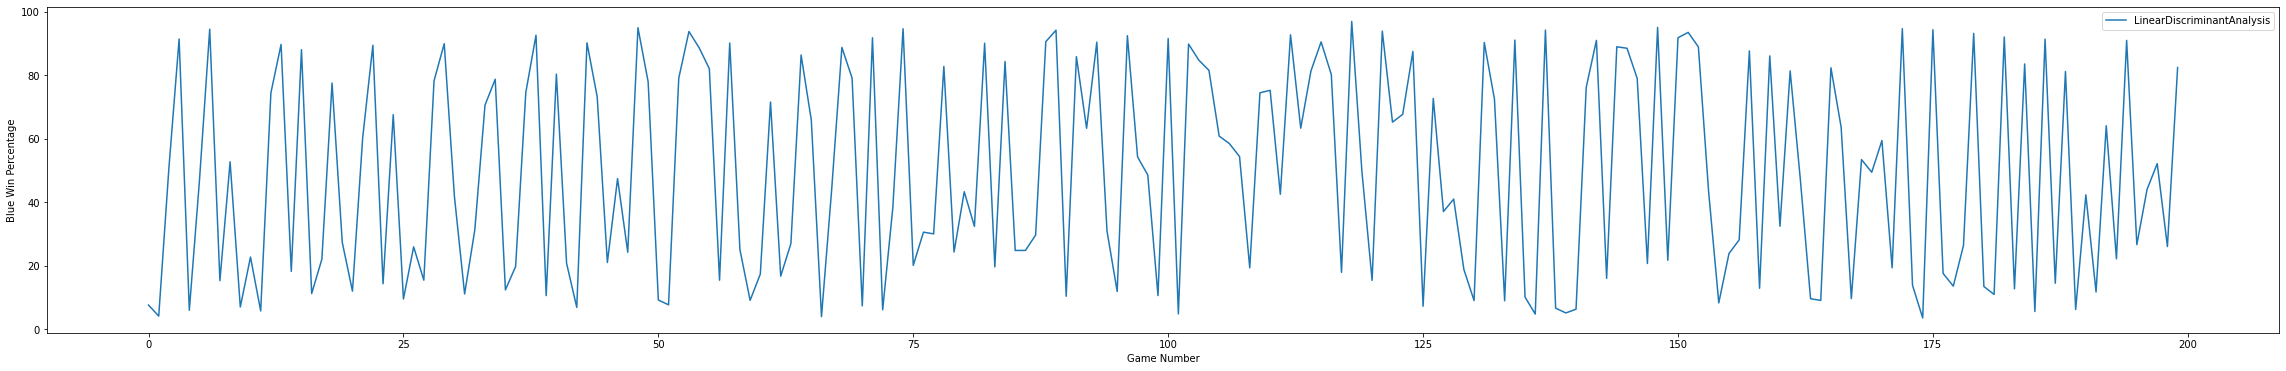

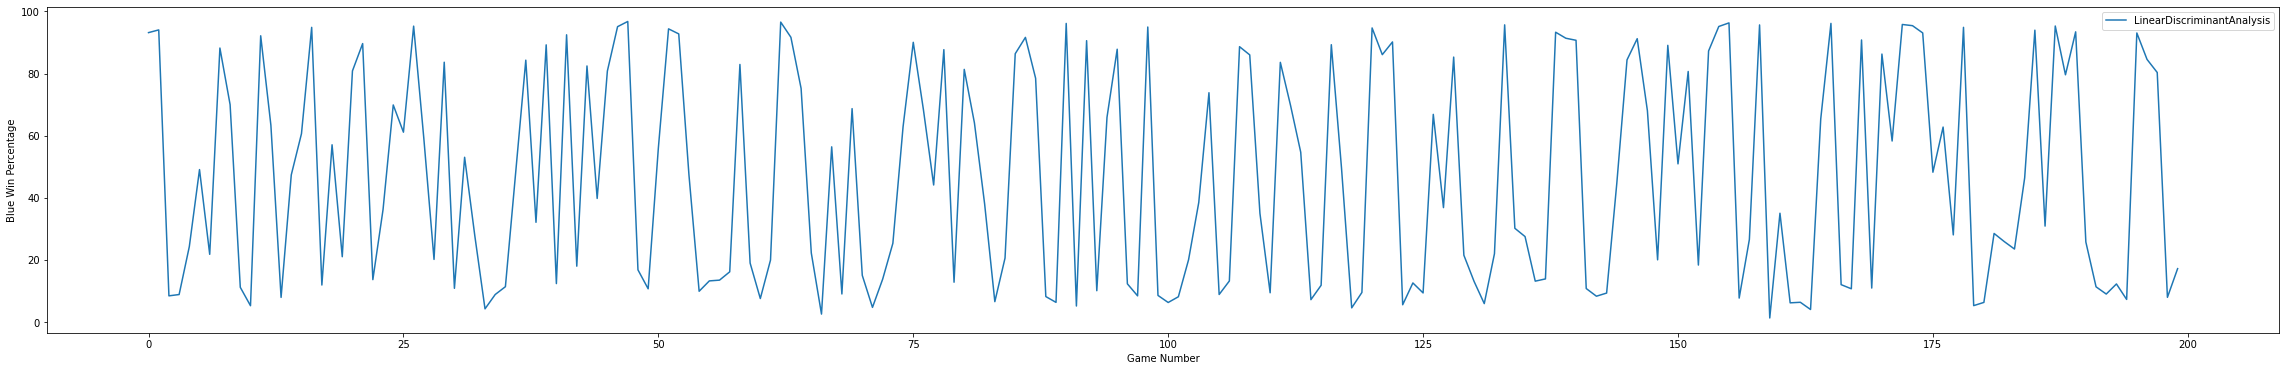

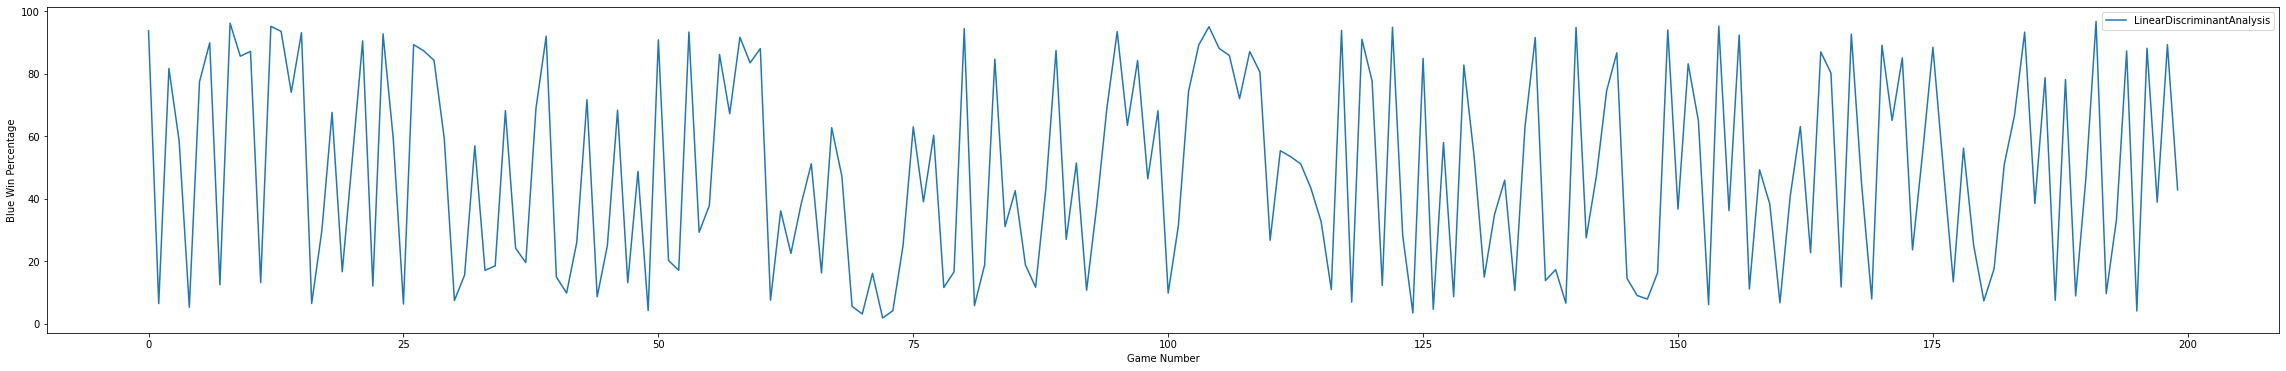

In [39]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'data/results/result_for_1k/1ksamples_LinearDiscriminantAnalysis_part_{i}.csv')

    y1 = data1['blue_win_percentage'].head(200)

    # Create a list of x values from 0 to the length of y1
    x = list(range(len(y1)))

    plt.figure(figsize=(40, 6))

    # Plot the four lines on the same graph
    plt.plot(x, y1, label='LinearDiscriminantAnalysis')

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()


**Dự đoán tỉ lệ thắng cho mỗi trận LOL sử dụng 5 fold cross validation dựa trên dữ liệu 10k samples bằng LogisticRegression, scaler PowerTransformer, thử nghiệm trên tập kiểm thử. Tính AUC để đánh giá tỉ lệ dự đoán của mô hình**

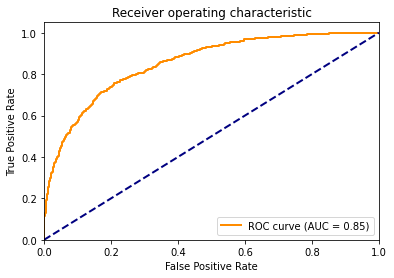

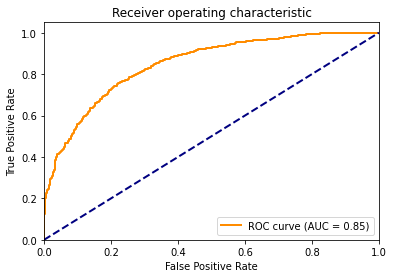

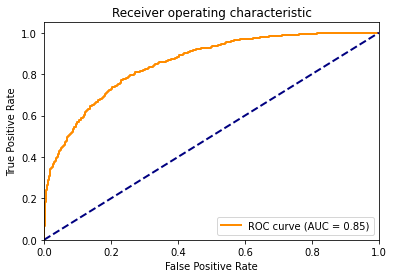

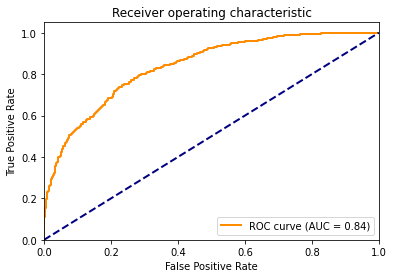

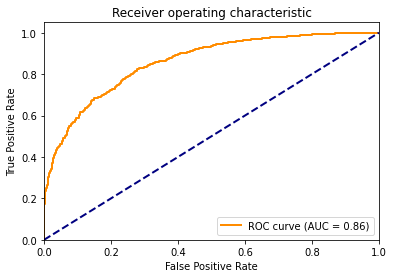

Mean AUC Score for model (StandardScaler(), LogisticRegression(random_state=42)): 0.8500049256804548, Elapsed_time: 0.06938980001723394


In [40]:
models = [(StandardScaler(), LogisticRegression(random_state=42))]
model_names = ["Logistic Regression"]
data = pd.read_csv("data/data_fe.csv")
dfs = []
X = data.drop('team_win', axis=1)
y = data['team_win']
j = 0

elapsed_times = 0
X_cols = X.columns.tolist()

for i, model in enumerate(models):
    auc_scores = []
    X = model[0].fit_transform(X)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        start_time = timeit.default_timer()
        X_train_scaled, X_test_scaled = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(model[1], LogisticRegression):
            clf = LogisticRegression(random_state=42)
        elif isinstance(model[1], LinearDiscriminantAnalysis):
            clf = LinearDiscriminantAnalysis()
        
        clf.fit(X_train_scaled, y_train)
                
        y_pred = clf.predict(X_test_scaled)
        
        # Predict the win probability for the test set
        win_prob = clf.predict_proba(X_test_scaled)[:, 1]
        
        elapsed_time = timeit.default_timer() - start_time

        # Convert win probability to win percentage
        win_percentages = win_prob * 100
        auc_score = roc_auc_score(y_test, win_prob)
        
        auc_scores.append(auc_score)

        X_test_df = pd.DataFrame(X_test_scaled, columns=X_cols)

        # Predict the results on the test set
        y_pred = clf.predict(X_test_df)

        data = []
        for k in range(len(X_test_df)):
            data.append({
                "blue_win_percentage": win_percentages[k],
                "red_win_percentage": 100 - win_percentages[k],
                "team_win": y_test.iloc[k],
                "team_pred": y_pred[k]
            })
        
        fpr, tpr, thresholds = roc_curve(y_test, win_prob)
        
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        # Create a DataFrame from the list of dicts
        df = pd.DataFrame(data)

        # Save the results to a CSV file
        model_name = model_names[i]
        df.to_csv(f"data/results/result_for_10k/10ksamples_{model_name}_part_{j}.csv", index=False)
        elapsed_times  = elapsed_times+ elapsed_time
    
    print(f"Mean AUC Score for model {model}: {np.mean(auc_scores)}, Elapsed_time: {elapsed_times}")


**Trực quan hóa tỉ lệ thắng dự đoán của mô hình trên các file kết quả**

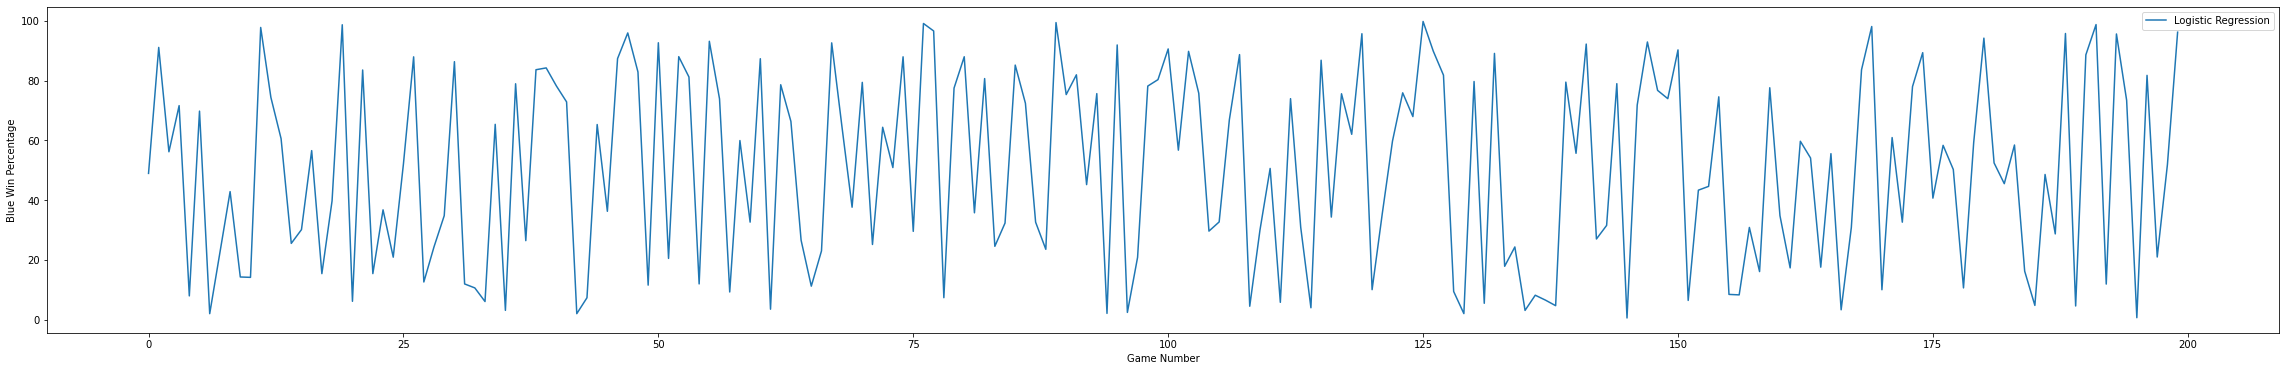

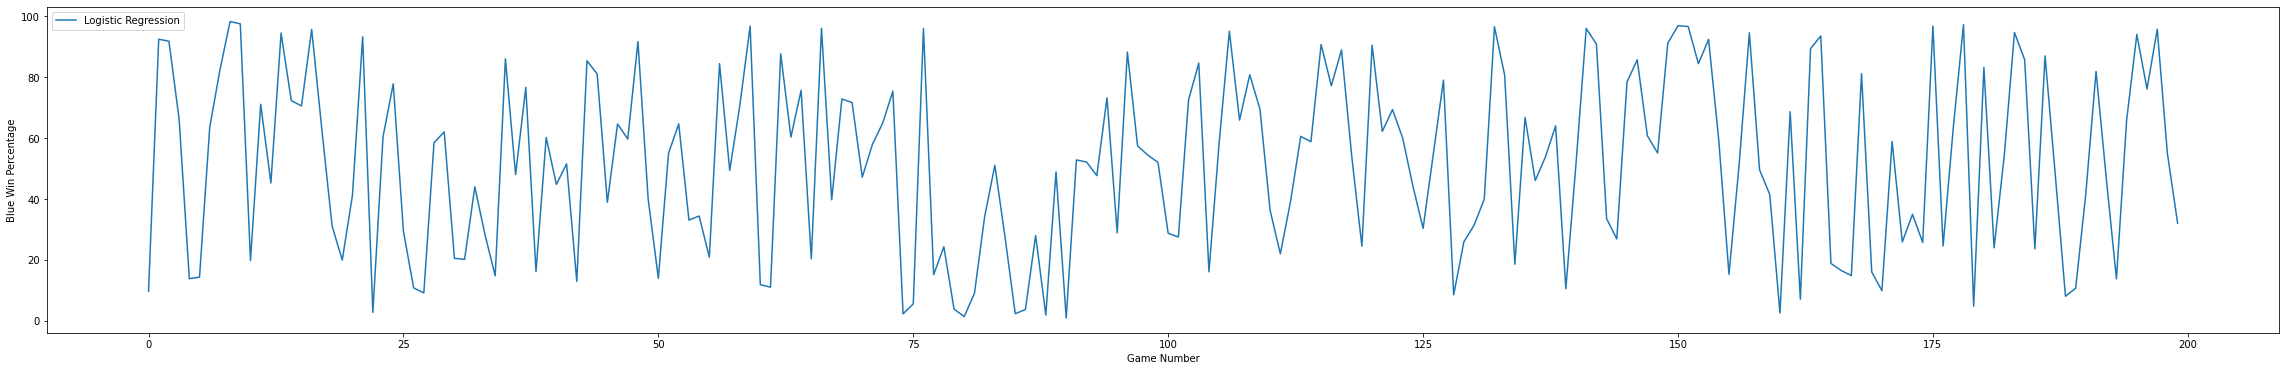

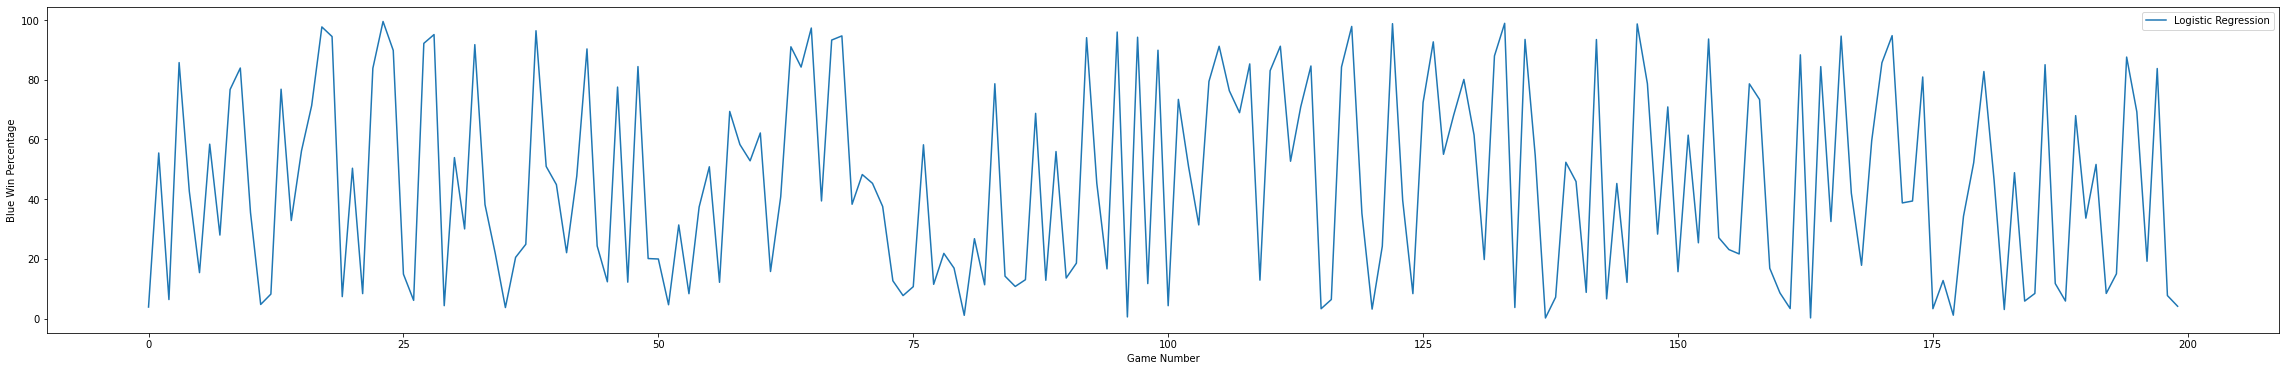

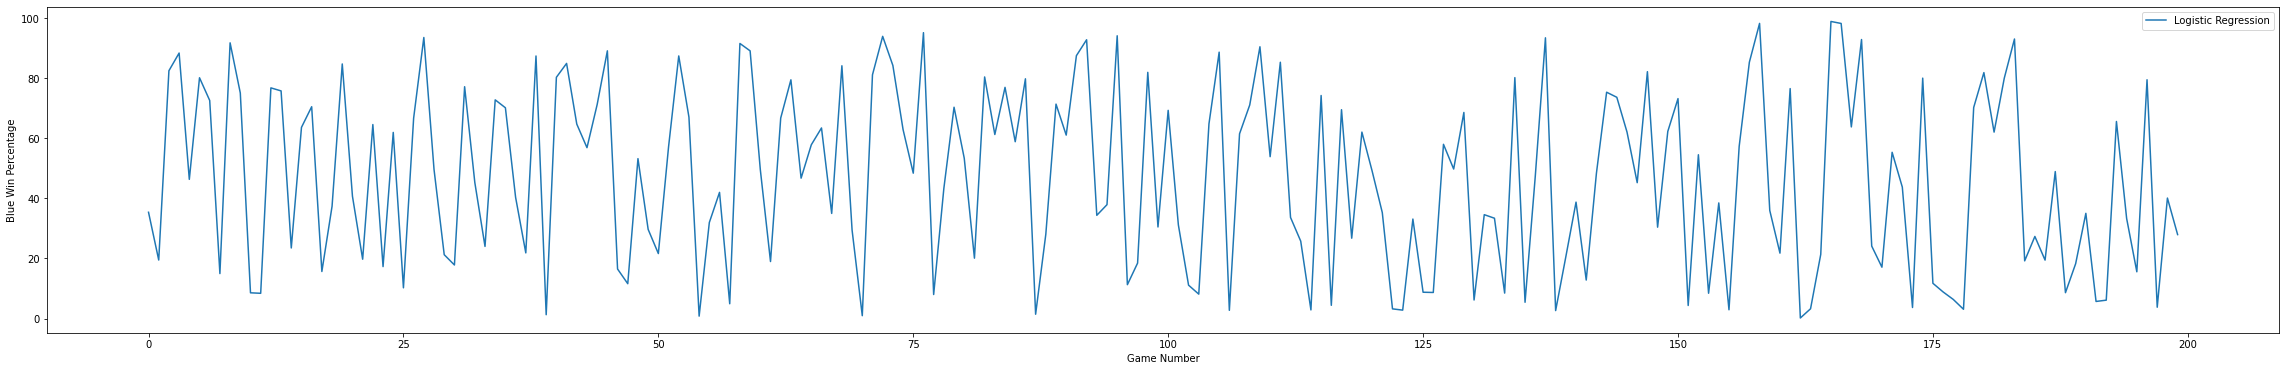

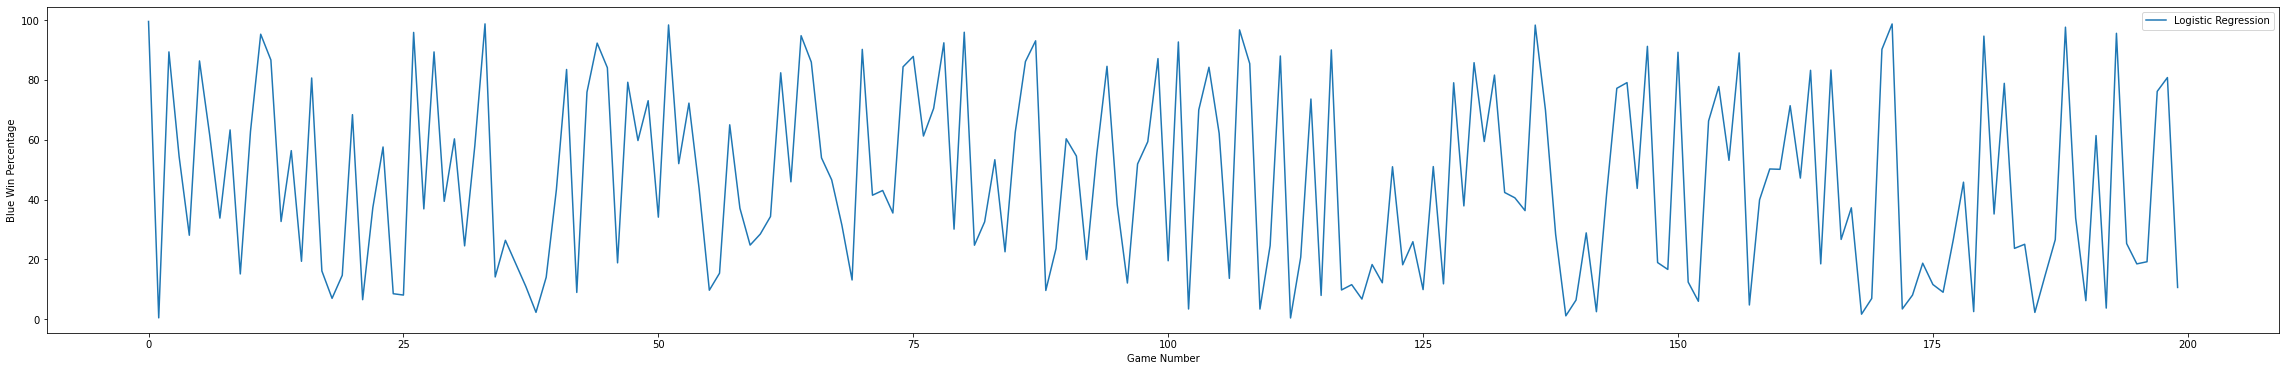

In [41]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'data/results/result_for_10k/10ksamples_Logistic Regression_part_{i}.csv')

    y1 = data1['blue_win_percentage'].head(200)

    # Create a list of x values from 0 to the length of y1
    x = list(range(len(y1)))

    plt.figure(figsize=(40, 6))

    # Plot the four lines on the same graph
    plt.plot(x, y1, label='Logistic Regression')

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()
